In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from SmallData import SmallDataset
from SmallUnet import SimpleUNet
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback

class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        train_loss = metrics.get("train_loss_epoch")
        val_loss = metrics.get("val_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        if val_loss is not None:
            self.val_losses.append(val_loss.item())


dataset_path = "dataset/multispectral_field_images"

dataset = SmallDataset(dataset_path)
print(dataset)

train_loader, val_loader, test_loader = dataset.produce_dataloaders()
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=7, out_channels=7, base_channels=32):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.out_conv = nn.Conv2d(base_channels, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        out = self.out_conv(d1)
        return out

# -----------------------------
# 3️⃣ PyTorch Lightning Module
# -----------------------------
class UNetLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = SimpleUNet()
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss
    
    def on_train_epoch_end(self):
        # Print all metrics for this epoch
        metrics = self.trainer.callback_metrics  # dictionary of all logged metrics
        epoch = self.current_epoch
        metric_str = ", ".join([f"{k}: {v:.6f}" for k, v in metrics.items()])
        print(f"Epoch {epoch+1}: {metric_str}")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# -----------------------------
# 5️⃣ Logger & Checkpoint
# -----------------------------
logger = TensorBoardLogger("tb_logs", name="unet_model")
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")
history_cb = HistoryCallback()

# -----------------------------
# 6️⃣ Trainer
# -----------------------------
trainer = pl.Trainer(
    max_epochs=50,
    logger=logger,
    callbacks=[checkpoint_callback, history_cb],
    accelerator="cpu",   # explicitly use CPU
    devices=1            # one CPU device
)

model = UNetLightning()
history = trainer.fit(model, train_loader, val_loader)

# -----------------------------
# 7️⃣ Model Architecture Visualization
# -----------------------------
from torchsummary import summary
x = torch.randn(1, 7, 96, 96)
summary(model.model, input_size=(7, 96, 96))

In [ ]:
plt.figure()
plt.semilogy(history_cb.train_losses, label="Train Loss")
plt.semilogy(history_cb.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training History")
plt.legend()
plt.show()


In [ ]:
# Get one batch from validation loader
x, y = next(iter(test_loader))  # x: (B, 7, 96, 96), y: (B, 7, 96, 96)
x, y = x.to("cpu"), y.to("cpu")

# Pick the first sample in batch
input_img = x[6]    # (7, 96, 96)
target_img = y[6]   # (7, 96, 96)

# Get model prediction
model.eval()
with torch.no_grad():
    pred_img = model(input_img.unsqueeze(0)).squeeze(0)  # (7, 96, 96)

# Compute difference (absolute error)
diff_img = torch.abs(target_img - pred_img)  # (7, 96, 96)

# Plot input, target, predicted, and difference
num_channels = input_img.shape[0]
fig, axes = plt.subplots(num_channels, 4, figsize=(16, num_channels*2))

for c in range(num_channels):
    axes[c, 0].imshow(input_img[c].numpy(), cmap="viridis")
    axes[c, 0].set_title(f"Input Ch {c}")
    axes[c, 0].axis("off")

    axes[c, 1].imshow(target_img[c].numpy(), cmap="viridis")
    axes[c, 1].set_title(f"Target Ch {c}")
    axes[c, 1].axis("off")

    axes[c, 2].imshow(pred_img[c].numpy(), cmap="viridis")
    axes[c, 2].set_title(f"Predicted Ch {c}")
    axes[c, 2].axis("off")

    axes[c, 3].imshow(diff_img[c].numpy(), cmap="magma")
    axes[c, 3].set_title(f"Diff Ch {c}")
    axes[c, 3].axis("off")

plt.tight_layout()
plt.show()


In [13]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np

from SentinelData import SentinelCroppedDataset


# ---------------------------------------------------------
# Utility: Display multispectral tensor as a grid of bands
# ---------------------------------------------------------
def show_ms_grid(ms_tensor, title=""):
    """
    ms_tensor: shape (C, H, W)
    Shows each band separately using a viridis colormap.
    """
    arr = ms_tensor.cpu().numpy()
    C = arr.shape[0]

    cols = 4
    rows = int(np.ceil(C / cols))

    plt.figure(figsize=(4 * cols, 3.5 * rows))
    for i in range(C):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(arr[i], cmap="viridis")
        plt.title(f"{title} | Band {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------
# Main visualization
# ---------------------------------------------------------
def visualize_one_sample(
    data_path,
    loader_type="train",       # "train", "val", or "test"
    batch_size=16,
    num_workers=2,
):
    """
    Load dataset, pick a random sample from the selected dataloader,
    and display RGB, low-res MS, and high-res MS tiles.
    """

    dataset = SentinelCroppedDataset(data_path)

    # Create dataloaders
    train_loader, val_loader, test_loader = dataset.produce_dataloaders(
        batch_size=batch_size,
        num_workers=num_workers,
    )

    # Pick loader
    if loader_type == "train":
        loader = train_loader
    elif loader_type == "val":
        loader = val_loader
    elif loader_type == "test":
        loader = test_loader
    else:
        raise ValueError("loader_type must be 'train', 'val', or 'test'.")

    # Convert loader to list so we can sample a batch randomly
    batches = list(loader)
    batch = random.choice(batches)

    (rgb_batch, ms_low_batch), ms_gt_batch = batch

    # Pick a random sample from the batch
    idx = random.randint(0, rgb_batch.size(0) - 1)

    rgb = rgb_batch[idx]          # (3, H, W)
    ms_low = ms_low_batch[idx]    # (C_mul, H2, W2)
    ms_gt = ms_gt_batch[idx]      # (C_out, H, W)

    # ---------------------------------------------------------
    # Plot RGB tile
    # ---------------------------------------------------------
    rgb_np = rgb.permute(1, 2, 0).numpy()

    # Normalize for display
    rgb_np = (rgb_np - rgb_np.min()) / (rgb_np.max() - rgb_np.min() + 1e-8)

    plt.figure(figsize=(6, 5))
    plt.imshow(rgb_np)
    plt.title("RGB Tile (High Resolution)")
    plt.axis("off")
    plt.show()

    # ---------------------------------------------------------
    # Plot Low-Res MS tile (128x64)
    # ---------------------------------------------------------
    show_ms_grid(ms_low, "Low-Res MS Input")

    # ---------------------------------------------------------
    # Plot Target High-Res MS tile (256x128)
    # ---------------------------------------------------------
    show_ms_grid(ms_gt, "High-Res MS Ground Truth")

    print("Displayed sample tiles from:", loader_type, "loader.")


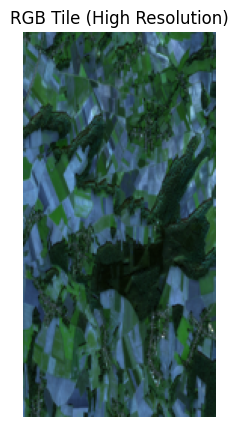

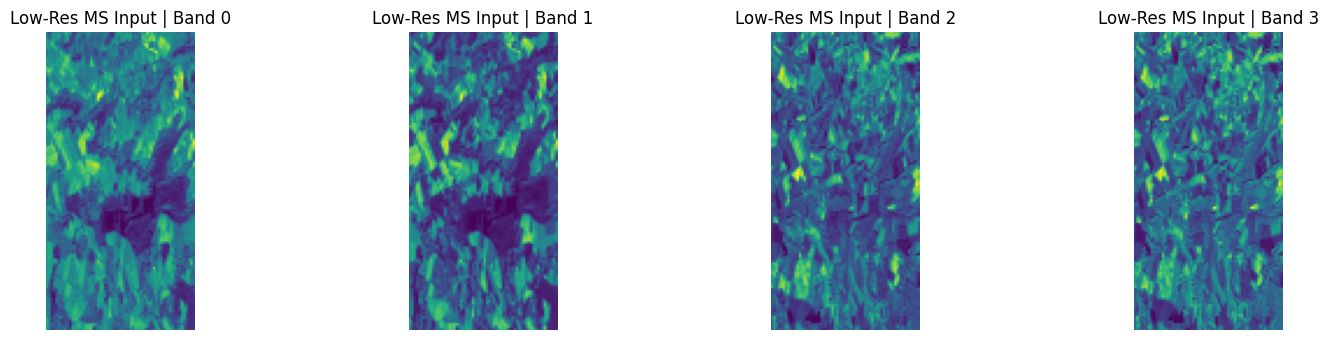

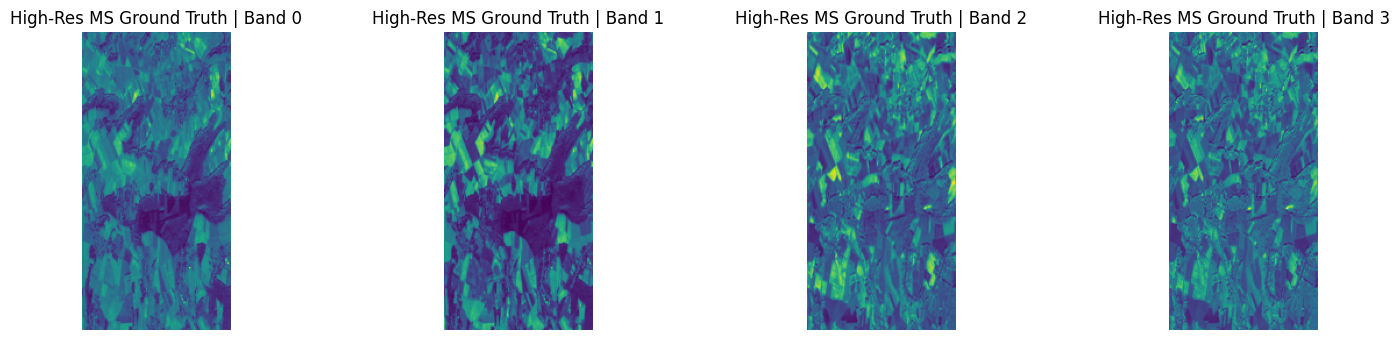

Displayed sample tiles from: train loader.


In [14]:
visualize_one_sample(
        data_path="/home/karolina/studia/GSN-2025W-PuchaczPansharpening/dataset_sentinel/",
        loader_type="train",    # or "val" or "test"
    )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Load Your Dataset
# ---------------------------------------------------------
from SentinelData import SentinelCroppedDataset
from ShallowUnetPansharpen import ShallowUNetPansharpen


def train_model(
    data_path,
    batch_size=16,
    lr=2e-4,
    num_epochs=50,
    num_workers=2,
    device=None
):
    # ---------------------------------------------------------
    # Device setup
    # ---------------------------------------------------------
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")

    # ---------------------------------------------------------
    # Dataset + Dataloaders
    # ---------------------------------------------------------
    dataset = SentinelCroppedDataset(data_path)

    train_len = int(0.8 * len(dataset))
    val_len   = len(dataset) - train_len

    train_ds, val_ds = torch.utils.data.random_split(dataset, [train_len, val_len])

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    # ---------------------------------------------------------
    # Create model
    # ---------------------------------------------------------
    # Get number of multispectral bands from dataset
    sample = dataset[0]
    x_rgb, x_mul = sample[0]
    _, y = sample

    n_ms_bands = y.shape[0]

    model = ShallowUNetPansharpen(
        n_ms_bands=n_ms_bands
    ).to(device)

    print(model)

    # ---------------------------------------------------------
    # Loss + optimizer
    # ---------------------------------------------------------
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler()

    # ---------------------------------------------------------
    # Loss history
    # ---------------------------------------------------------
    train_losses = []
    val_losses = []

    # ---------------------------------------------------------
    # Training Loop
    # ---------------------------------------------------------
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for (rgb, ms_low), ms_gt in train_loader:
            rgb     = rgb.to(device)
            ms_low  = ms_low.to(device)
            ms_gt   = ms_gt.to(device)

            optimizer.zero_grad()

            # AMP forward
            with autocast(device_type='cuda'):
                output = model(rgb, ms_low)
                loss = criterion(output, ms_gt)

            # AMP backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * rgb.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # ------------------------------------------
        # Validation
        # ------------------------------------------
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for (rgb, ms_low), ms_gt in val_loader:
                rgb     = rgb.to(device)
                ms_low  = ms_low.to(device)
                ms_gt   = ms_gt.to(device)

                with autocast(device_type='cuda'):
                    output = model(rgb, ms_low)
                    loss = criterion(output, ms_gt)

                val_loss += loss.item() * rgb.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"[{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # ------------------------------------------
        # Save checkpoint
        # ------------------------------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_pansharpening_unet.pth")
            print("Saved new best model")

    print("Training completed.")

    # ---------------------------------------------------------
    # Plot losses
    # ---------------------------------------------------------
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()

    return model

In [ ]:
data_path = Path("/home/karolina/studia/GSN-2025W-PuchaczPansharpening/dataset_sentinel/")
model = train_model(data_path)

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from SentinelData import SentinelCroppedDataset
from ShallowUnetPansharpen import ShallowUNetPansharpen


# ----------------------------------------------------
# Utility: visualize multispectral grid
# ----------------------------------------------------
def show_ms_grid(ms, title=""):
    """
    ms: (C, H, W)
    """
    ms = ms.cpu().numpy()
    C = ms.shape[0]

    cols = 4
    rows = int(np.ceil(C / cols))

    plt.figure(figsize=(4 * cols, 4 * rows))
    for i in range(C):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(ms[i], cmap="viridis")
        plt.title(f"{title} | band {i}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------
# Main evaluation function
# ----------------------------------------------------
def evaluate_model(
    data_path,
    checkpoint_path="best_pansharpening_unet.pth",
    num_workers=8,
    device=None,
    max_samples=10,
):
    # ----------------------------------------------------
    # Device
    # ----------------------------------------------------
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Evaluating on:", device)

    # ----------------------------------------------------
    # Load dataset and its loaders
    # ----------------------------------------------------
    dataset = SentinelCroppedDataset(data_path)
    train_loader, val_loader, test_loader = dataset.produce_dataloaders(
        batch_size=1,
        num_workers=num_workers,
        train_frac=0.7,
        val_frac=0.2
    )

    # ----------------------------------------------------
    # Create model with correct band count
    # ----------------------------------------------------
    sample = dataset[0]
    (rgb_sample, ms_low_sample), ms_gt_sample = sample

    model = ShallowUNetPansharpen(
        n_ms_bands=ms_low_sample.shape[0],
        base_channels=32,
        use_bn=True
    ).to(device)

    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    print("Loaded model from:", checkpoint_path)

    # ----------------------------------------------------
    # Iterate over test dataset
    # ----------------------------------------------------
    count = 0
    for (rgb, ms_low), ms_gt in test_loader:

        rgb = rgb.to(device)
        ms_low = ms_low.to(device)
        ms_gt = ms_gt.to(device)

        with torch.no_grad():
            ms_pred = model(rgb, ms_low)

        # ----------------------------------------------------
        # Visualization
        # ----------------------------------------------------
        # --- RGB ---
        rgb_np = rgb[0].cpu().permute(1, 2, 0).numpy()
        rgb_np = (rgb_np - rgb_np.min()) / (rgb_np.max() - rgb_np.min() + 1e-8)

        plt.figure(figsize=(6, 5))
        plt.imshow(rgb_np)
        plt.title("RGB Input (high-res)")
        plt.axis("off")
        plt.show()

        # --- MS inputs / outputs ---
        show_ms_grid(ms_low[0], "Low-res MS Input")
        show_ms_grid(ms_gt[0],  "GT MS High-res")
        show_ms_grid(ms_pred[0],"Predicted MS High-res")

        count += 1
        if count >= max_samples:
            break

    print("Evaluation complete.")

In [ ]:
evaluate_model(
        data_path=data_path,
        checkpoint_path="./best_pansharpening_unet.pth"
    )

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from SentinelData import SentinelCroppedDataset
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import random

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_ch, base_ch=32):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base_ch)
        self.enc2 = ConvBlock(base_ch, base_ch * 2)
        self.enc3 = ConvBlock(base_ch * 2, base_ch * 4)

        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        f1 = self.enc1(x)          # H, W
        f2 = self.enc2(self.pool(f1))  # H/2
        f3 = self.enc3(self.pool(f2))  # H/4
        return f1, f2, f3

In [4]:
class Decoder(nn.Module):
    def __init__(self, base_ch=32, out_ch=4):
        super().__init__()
        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)
        self.dec2 = ConvBlock(base_ch * 4, base_ch * 2)

        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)
        self.dec1 = ConvBlock(base_ch * 2, base_ch)

        self.out_conv = nn.Conv2d(base_ch, out_ch, 1)

    def forward(self, f1, f2, f3):
        x = self.up2(f3)
        x = self.dec2(torch.cat([x, f2], dim=1))

        x = self.up1(x)
        x = self.dec1(torch.cat([x, f1], dim=1))

        return self.out_conv(x)

In [5]:
def normalize(x, mean, std):
    return (x - mean[None, :, None, None]) / std[None, :, None, None]

def denormalize(x, mean, std):
    return x * std[None, :, None, None] + mean[None, :, None, None]

In [11]:
class PanSharpenLightning(pl.LightningModule):
    def __init__(
            self,
            rgb_mean=None,
            rgb_std=None,
            ms_mean=None,
            ms_std=None,
            base_ch=32,
            lr=1e-4,
        ):
        super().__init__()
        self.save_hyperparameters(ignore=["rgb_mean", "rgb_std", "ms_mean", "ms_std"])

        # Defaults if loading from checkpoint
        if rgb_mean is None:
            rgb_mean = torch.zeros(3)
        if rgb_std is None:
            rgb_std = torch.ones(3)
        if ms_mean is None:
            ms_mean = torch.zeros(4)
        if ms_std is None:
            ms_std = torch.ones(4)

        self.register_buffer("rgb_mean", torch.as_tensor(rgb_mean))
        self.register_buffer("rgb_std",  torch.as_tensor(rgb_std))
        self.register_buffer("ms_mean",  torch.as_tensor(ms_mean))
        self.register_buffer("ms_std",   torch.as_tensor(ms_std))

        self.rgb_encoder = Encoder(3, base_ch)
        self.ms_encoder  = Encoder(4, base_ch)

        self.fuse1 = nn.Conv2d(base_ch * 2, base_ch, 1)
        self.fuse2 = nn.Conv2d(base_ch * 4, base_ch * 2, 1)
        self.fuse3 = nn.Conv2d(base_ch * 8, base_ch * 4, 1)

        self.decoder = Decoder(base_ch, out_ch=4)
        self.loss_fn = nn.L1Loss()

    def forward(self, rgb, ms_lr):
        # --- Normalize inputs ---
        rgb = normalize(rgb, self.rgb_mean, self.rgb_std)
        ms_lr = normalize(ms_lr, self.ms_mean, self.ms_std)

        # Upsample MS to RGB resolution
        ms_up = F.interpolate(ms_lr, size=rgb.shape[-2:], mode="bilinear", align_corners=False)

        rgb_f1, rgb_f2, rgb_f3 = self.rgb_encoder(rgb)
        ms_f1,  ms_f2,  ms_f3  = self.ms_encoder(ms_up)

        f1 = self.fuse1(torch.cat([rgb_f1, ms_f1], dim=1))
        f2 = self.fuse2(torch.cat([rgb_f2, ms_f2], dim=1))
        f3 = self.fuse3(torch.cat([rgb_f3, ms_f3], dim=1))

        delta_ms = self.decoder(f1, f2, f3)

        # Residual prediction (still normalized space)
        ms_hr_norm = ms_up + delta_ms

        return ms_hr_norm

    def training_step(self, batch, batch_idx):
        (rgb, ms_lr), ms_hr = batch
        # Normalize GT MS
        ms_hr_norm = normalize(ms_hr, self.ms_mean, self.ms_std)
        pred_norm = self(rgb, ms_lr)
        loss = self.loss_fn(pred_norm, ms_hr_norm)
        self.log("train_l1", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        (rgb, ms_lr), ms_hr = batch
        ms_hr_norm = normalize(ms_hr, self.ms_mean, self.ms_std)
        pred_norm = self(rgb, ms_lr)
        loss = self.loss_fn(pred_norm, ms_hr_norm)
        self.log("val_l1", loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        (rgb, ms_lr), ms_hr = batch
        pred_norm = self(rgb, ms_lr)
        # Denormalize output for inference
        pred = denormalize(pred_norm, self.ms_mean, self.ms_std)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=10, factor=0.5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_l1"
            }
        }

In [7]:
def compute_stats(dataloader):
    rgb_sum = rgb_sq = ms_sum = ms_sq = 0
    n = 0

    for (rgb, ms_lr), _ in dataloader:
        b = rgb.size(0)
        rgb_sum += rgb.mean(dim=[0, 2, 3]) * b
        rgb_sq  += (rgb ** 2).mean(dim=[0, 2, 3]) * b

        ms_sum += ms_lr.mean(dim=[0, 2, 3]) * b
        ms_sq  += (ms_lr ** 2).mean(dim=[0, 2, 3]) * b
        n += b

    rgb_mean = rgb_sum / n
    rgb_std  = (rgb_sq / n - rgb_mean ** 2).sqrt()

    ms_mean = ms_sum / n
    ms_std  = (ms_sq / n - ms_mean ** 2).sqrt()

    return rgb_mean, rgb_std, ms_mean, ms_std

In [12]:
dataset = SentinelCroppedDataset("/home/karolina/studia/GSN-2025W-PuchaczPansharpening/dataset_sentinel/")
train_loader, val_loader, test_loader = dataset.produce_dataloaders()
rgb_mean, rgb_std, ms_mean, ms_std = compute_stats(train_loader)

# model = PanSharpenLightning(rgb_mean, rgb_std, ms_mean, ms_std, base_ch=32, lr=1e-4)

# trainer = pl.Trainer(
#     accelerator="gpu" if torch.cuda.is_available() else "cpu",
#     devices=1,
#     max_epochs=200,
#     precision=16,                     # mixed precision
#     callbacks=[
#         ModelCheckpoint(
#             monitor="val_l1",
#             save_top_k=1,
#             mode="min",
#             filename="pansharpen-{epoch:03d}-{val_l1:.4f}"
#         ),
#         EarlyStopping(
#             monitor="val_l1",
#             patience=20,
#             mode="min"
#         )
#     ],
#     log_every_n_steps=4
# )

# trainer.fit(model, train_loader, val_loader)

In [13]:
ckpt_path = "/home/karolina/studia/GSN-2025W-PuchaczPansharpening/lightning_logs/version_4/checkpoints/pansharpen-epoch=197-val_l1=0.0348.ckpt"

model = PanSharpenLightning.load_from_checkpoint(
    ckpt_path,
    map_location="cuda"  # or "cuda"
)

model.eval()

2025-12-15 08:17:09,234 - fsspec.local - DEBUG - open file: /home/karolina/studia/GSN-2025W-PuchaczPansharpening/lightning_logs/version_4/checkpoints/pansharpen-epoch=197-val_l1=0.0348.ckpt


PanSharpenLightning(
  (rgb_encoder): Encoder(
    (enc1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (enc2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (enc3)

In [15]:
import torch
import torch.nn.functional as F

device = next(model.parameters()).device

l1_total = 0.0
mse_total = 0.0
n_samples = 0

with torch.no_grad():
    for batch in test_loader:
        (rgb, ms_lr), ms_hr = batch

        rgb = rgb.to(device)
        ms_lr = ms_lr.to(device)
        ms_hr = ms_hr.to(device)

        # Forward (normalized space)
        pred_norm = model(rgb, ms_lr)

        # Denormalize prediction
        pred = (
            pred_norm
            * model.ms_std[None, :, None, None]
            + model.ms_mean[None, :, None, None]
        )

        # Metrics
        l1 = F.l1_loss(pred, ms_hr, reduction="sum")
        mse = F.mse_loss(pred, ms_hr, reduction="sum")

        l1_total += l1.item()
        mse_total += mse.item()
        n_samples += ms_hr.numel()

l1_mean = l1_total / n_samples
mse_mean = mse_total / n_samples

print(f"Test L1  : {l1_mean:.6f}")
print(f"Test MSE : {mse_mean:.6f}")


Test L1  : 42.113837
Test MSE : 7225.665365


In [30]:
def normalize_img(x):
    x = x - x.min()
    x = x / (x.max() + 1e-8)
    return x

def plot_pansharpen_examples(
    model,
    test_loader,
    num_samples=5,
):
    device = next(model.parameters()).device
    model.eval()

    # Get one batch large enough
    batch = next(iter(test_loader))
    (rgb, ms_lr), ms_hr = batch
    rgb = rgb.to(device)
    ms_lr = ms_lr.to(device)
    ms_hr = ms_hr.to(device)
    # (rgb, ms_lr), ms_hr = [x.to(device) for x in batch]

    B = rgb.size(0)
    idxs = random.sample(range(B), min(num_samples, B))

    with torch.no_grad():
        # Forward
        pred_norm = model(rgb, ms_lr)
        pred = (
            pred_norm
            * model.ms_std[None, :, None, None]
            + model.ms_mean[None, :, None, None]
        )

        # Upsample MS input for visualization
        ms_lr_up = F.interpolate(
            ms_lr,
            size=pred.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

    for i, idx in enumerate(idxs):
        fig = plt.figure(figsize=(15, 25))
        fig.suptitle(f"Sample {idx}", fontsize=16)

        # ---- RGB ----
        ax = plt.subplot2grid((5, 4), (0, 0), colspan=4)
        rgb_img = rgb[idx].permute(1, 2, 0).cpu()
        ax.imshow(normalize_img(rgb_img))
        ax.set_title("RGB input")
        ax.axis("off")

        # ---- MS bands ----
        for b in range(4):
            # MS LR
            ax = plt.subplot2grid((5, 4), (b + 1, 0))
            ax.imshow(normalize_img(ms_lr_up[idx, b].cpu()), cmap="gray")
            ax.set_title(f"MS LR band {b}")
            ax.axis("off")

            # Prediction
            ax = plt.subplot2grid((5, 4), (b + 1, 1))
            ax.imshow(normalize_img(pred[idx, b].cpu()), cmap="gray")
            ax.set_title(f"Pred band {b}")
            ax.axis("off")

            # GT
            ax = plt.subplot2grid((5, 4), (b + 1, 2))
            ax.imshow(normalize_img(ms_hr[idx, b].cpu()), cmap="gray")
            ax.set_title(f"GT band {b}")
            ax.axis("off")

            # Error
            ax = plt.subplot2grid((5, 4), (b + 1, 3))
            err = (pred[idx, b] - ms_hr[idx, b]).abs()
            ax.imshow(normalize_img(err.cpu()), cmap="hot")
            ax.set_title(f"Error band {b}")
            ax.axis("off")

        # plt.tight_layout()
        plt.show()


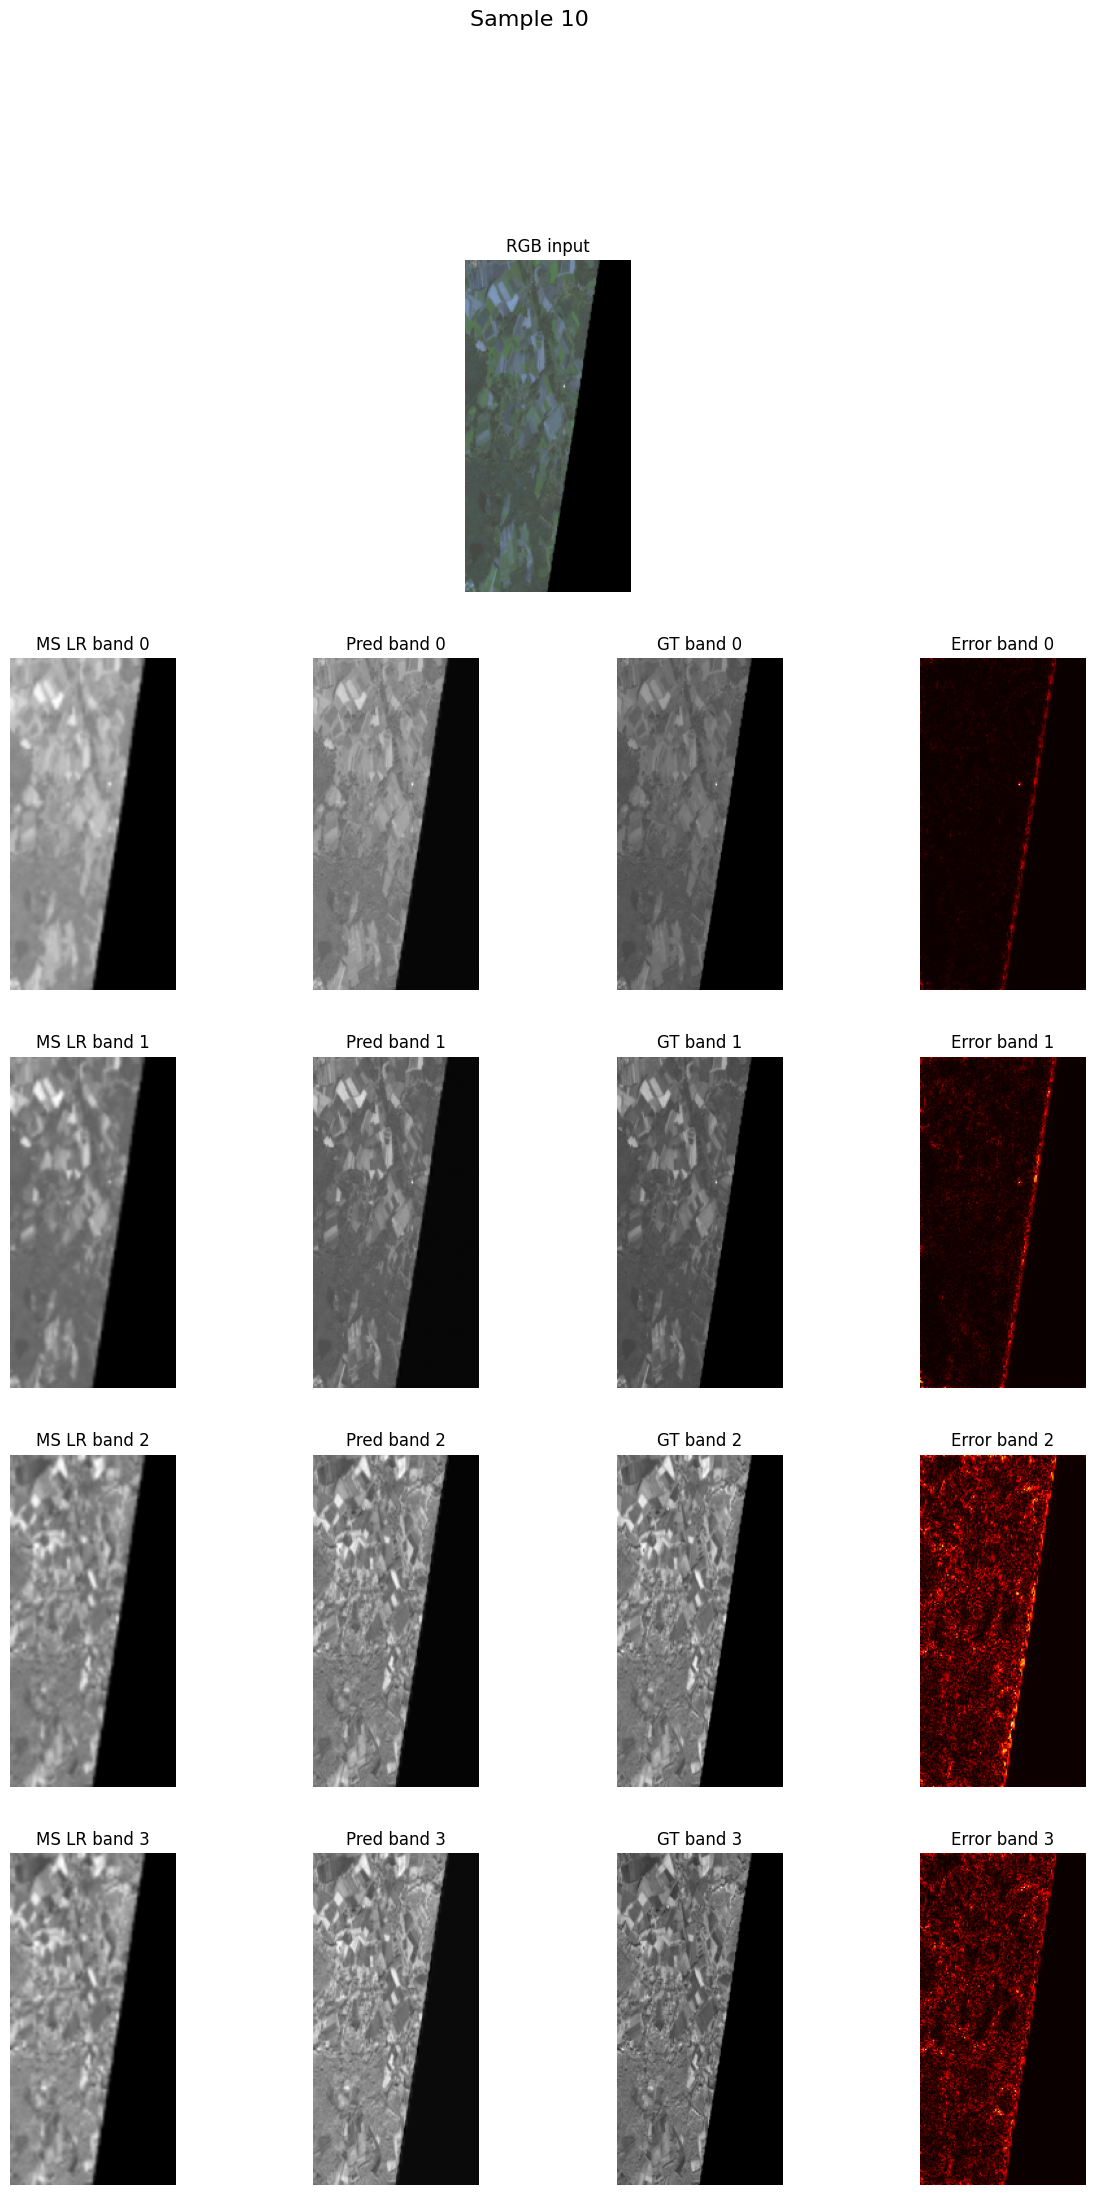

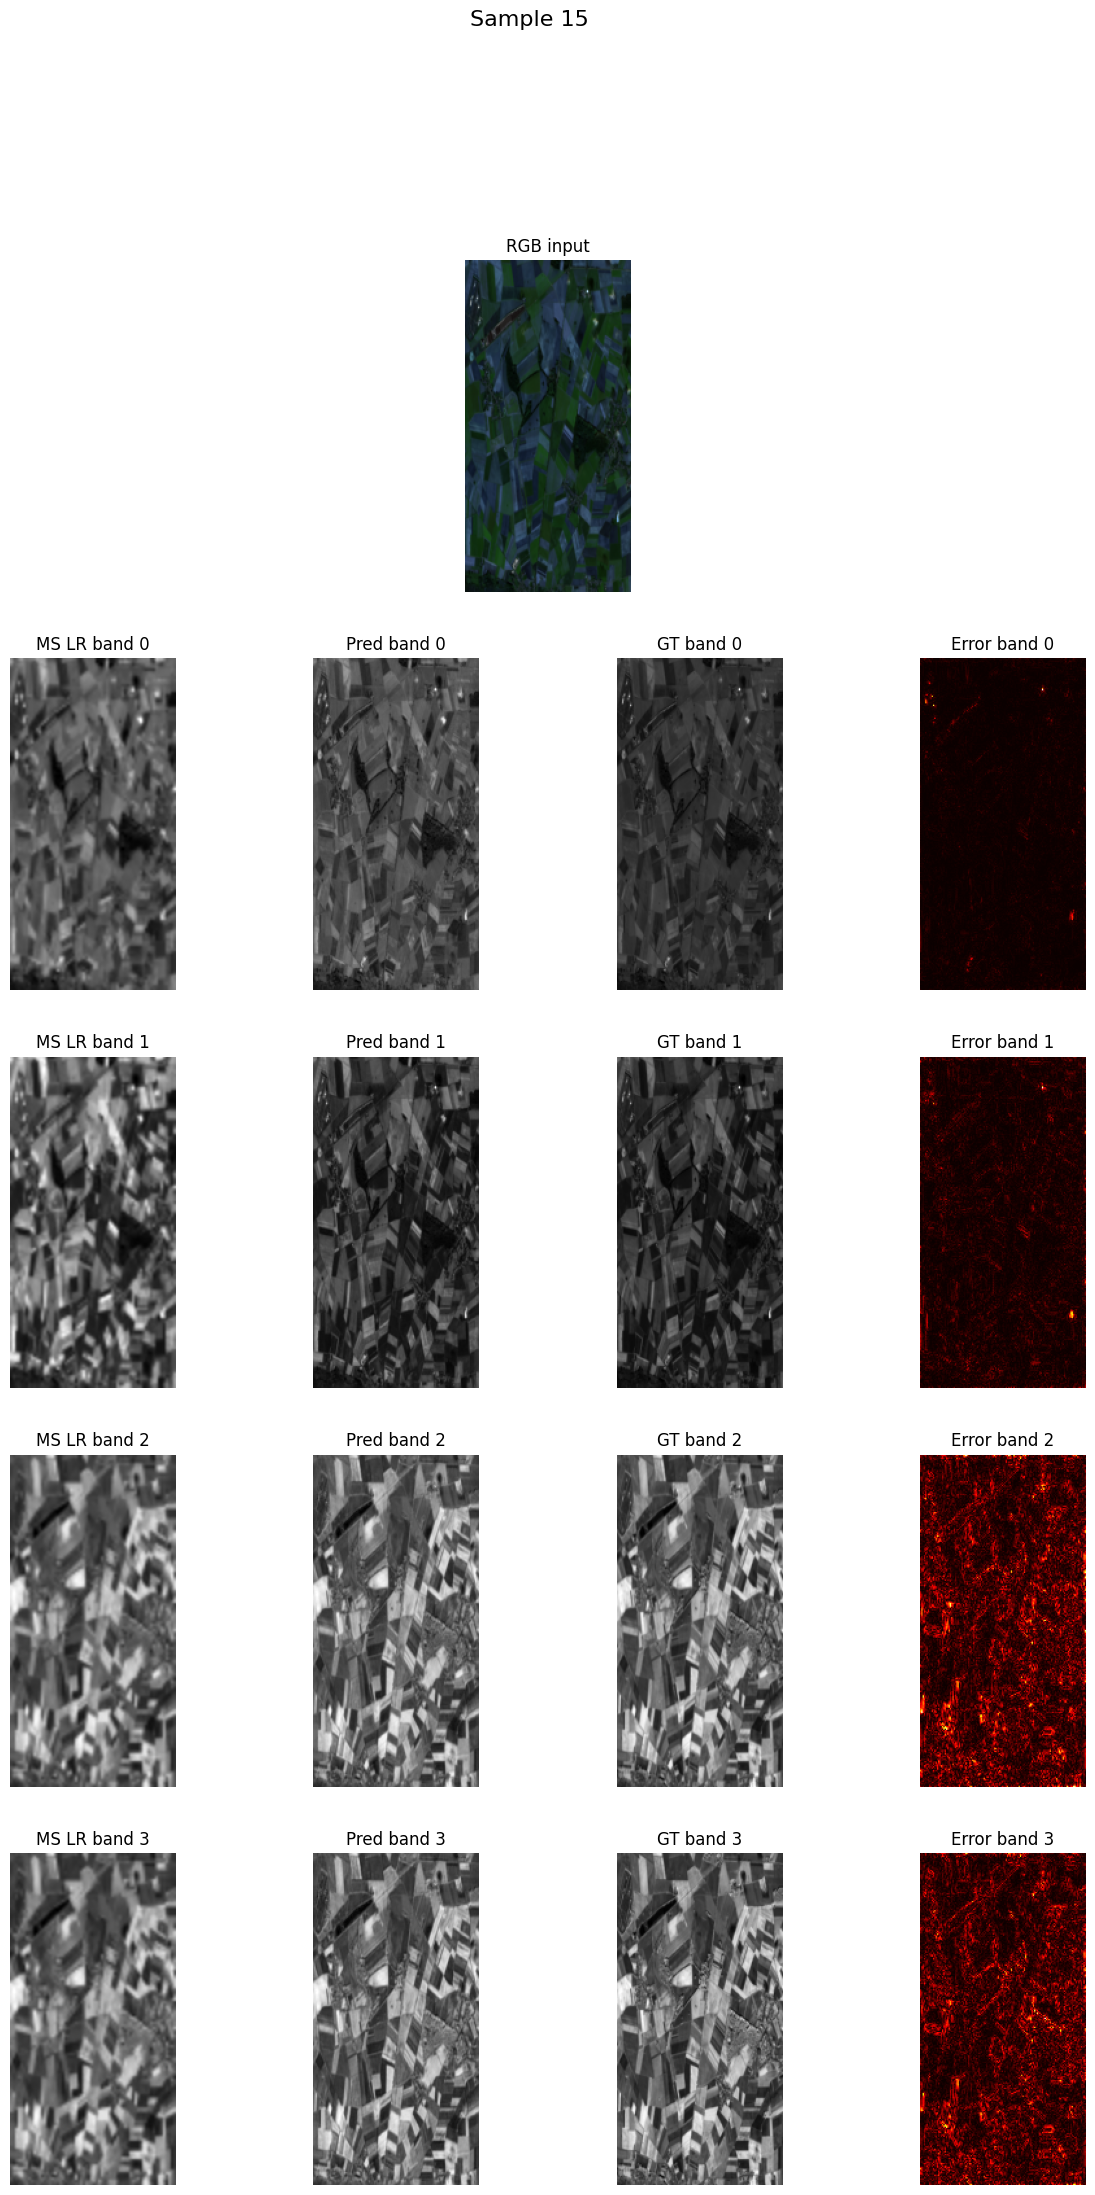

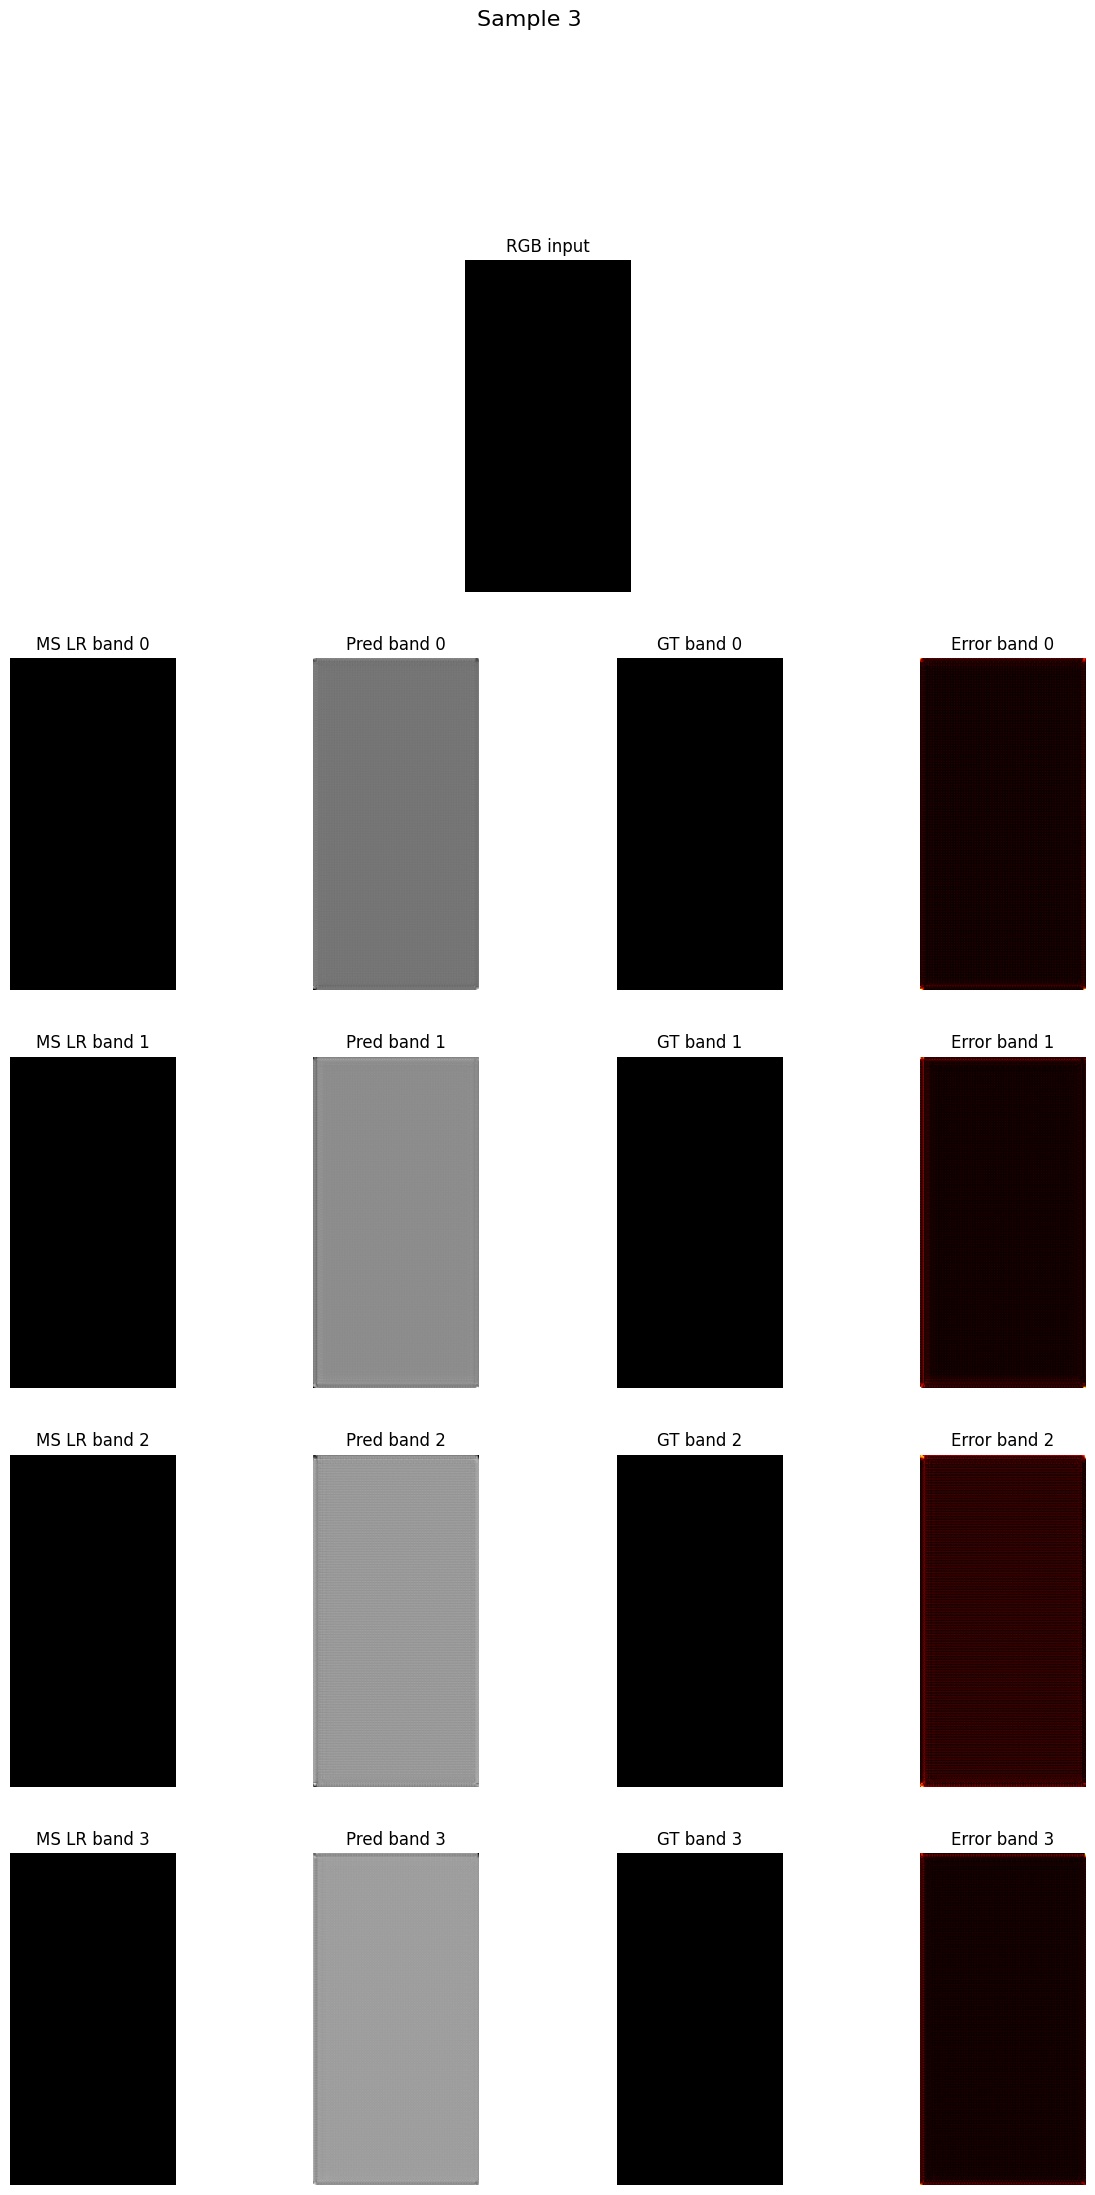

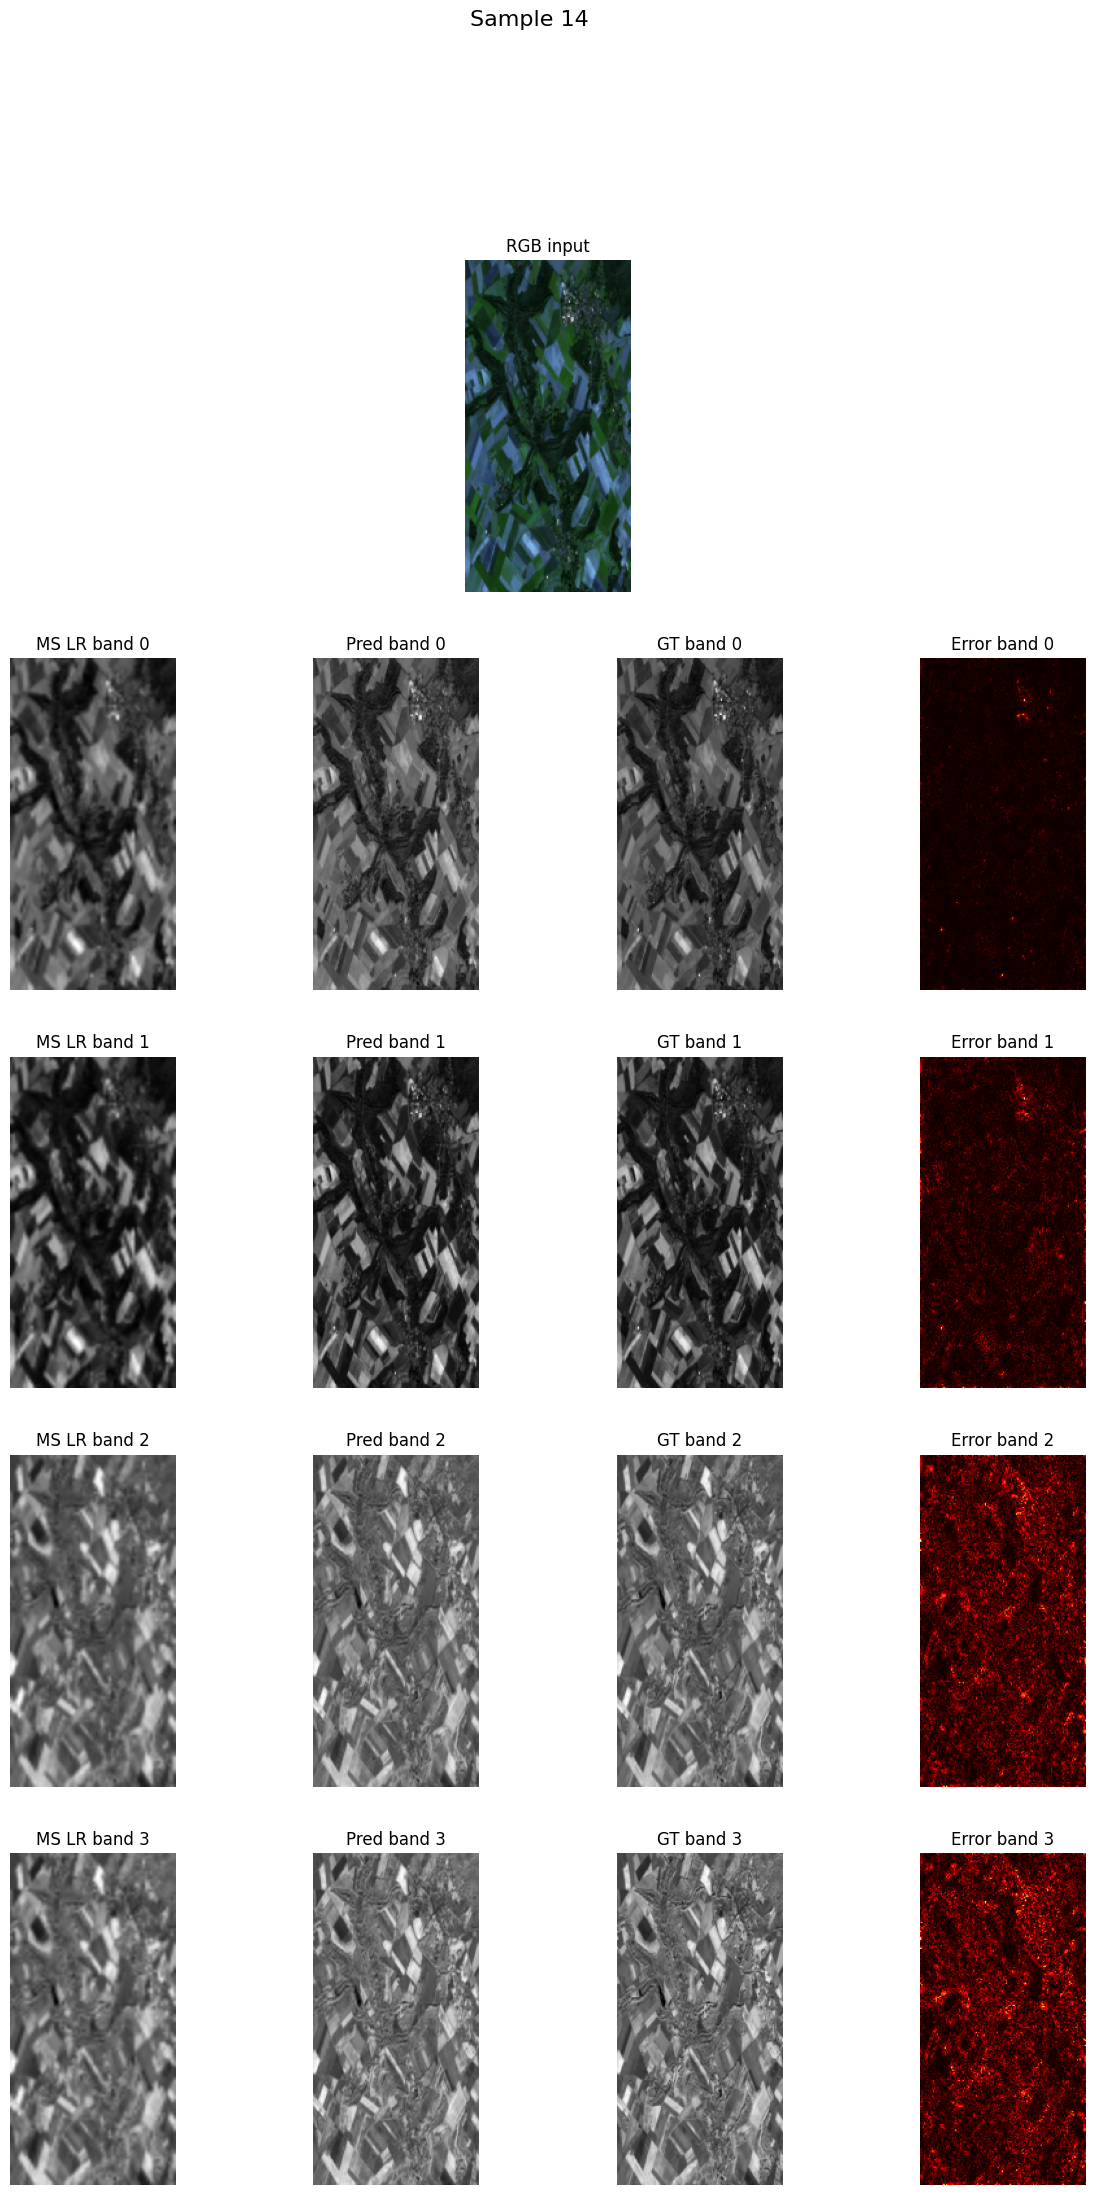

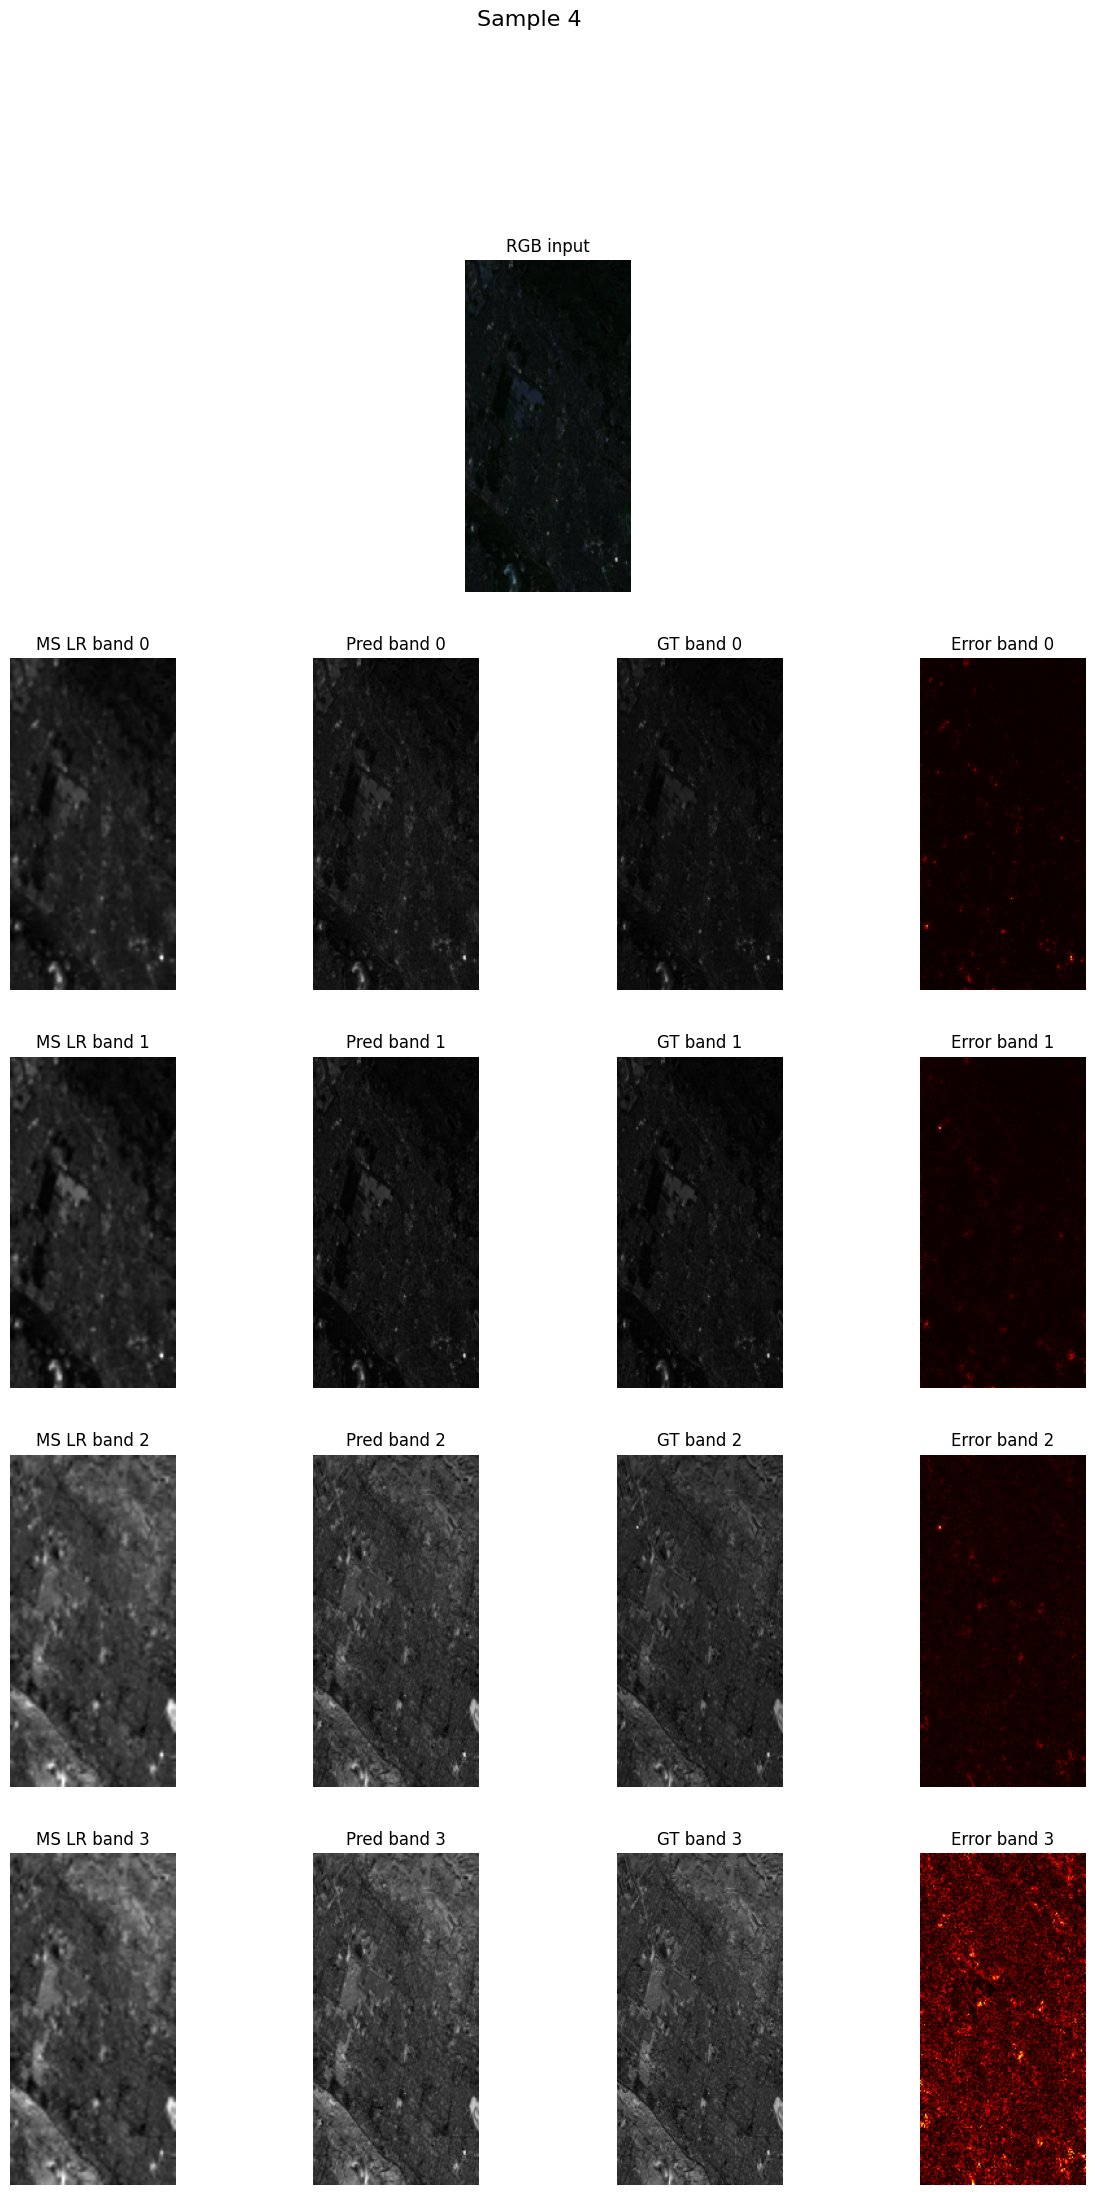

In [31]:
plot_pansharpen_examples(
    model=model,
    test_loader=test_loader,
    num_samples=5,
)